<a href="https://colab.research.google.com/github/olaidejoseph/g02-sms-spam/blob/master/LSTMSpamnew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from keras.optimizers import SGD, Adam, RMSprop



embedding_dim = 100
max_length = 150
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"



In [2]:
#!wget 'https://raw.githubusercontent.com/HamoyeHQ/g02-sms-spam/master/data/spam_additional.csv'
#!wget 'https://raw.githubusercontent.com/HamoyeHQ/g02-sms-spam/master/data/spam.csv'

--2020-12-05 14:12:36--  https://raw.githubusercontent.com/HamoyeHQ/g02-sms-spam/master/data/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/plain]
Saving to: ‘spam.csv.10’

spam.csv.10         100%[===================>] 491.86K  --.-KB/s    in 0.007s  

2020-12-05 14:12:37 (68.4 MB/s) - ‘spam.csv.10’ saved [503663/503663]



In [3]:
data = pd.read_csv('/content/spam.csv.1', engine='python')
data2 = pd.read_csv('/content/spam_additional.csv')


In [4]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
data2.head()

,Unnamed: 0,Text,spam
0,0,"Dear Customer,\nThis is a confirmation that th...",spam
1,1,"Hello ADEYINKA, present your CV for interview ...",spam
2,2,Edgerit Limited invites you for an interview f...,spam
3,3,You are invited for an aptitude test with UBA ...,spam
4,4,"Mag consult ltd, shortlisted (you/candidate no...",spam


In [6]:
data.dropna(inplace=True,axis=1)
data.rename(columns={"v1":"label","v2":"message"},inplace=True)

In [7]:
data2 = data2[['Text','spam']].copy()
data2.rename(columns={"spam":"label","Text":"message"},inplace=True)

In [8]:
# merge the datframes
data = data.append(data2)

In [9]:
# To drop duplicated rows
data.drop_duplicates(inplace=True)

In [10]:
# shuffle rows
data = data.sample(frac = 1).reset_index(drop=True)

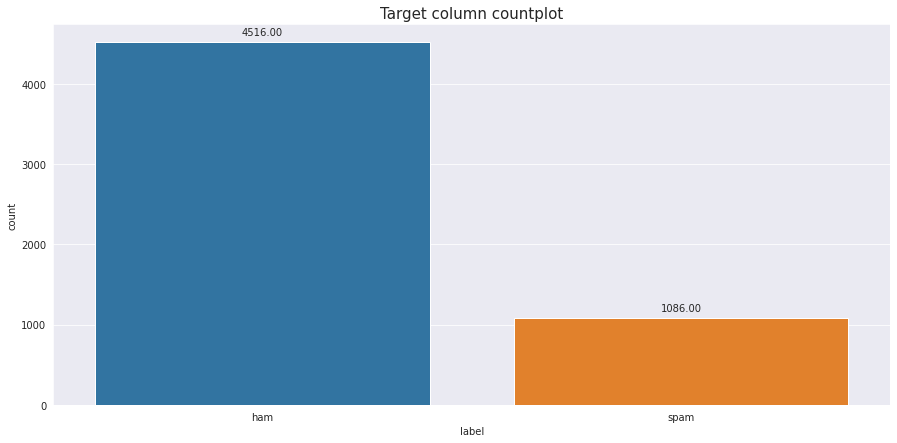

In [11]:
plt.figure(figsize=(15,7))
sns.set_style("darkgrid")
splot = sns.countplot(x="label",data=data)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), \
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title('Target column countplot', size=15)
plt.show()

The data target is highly imbalance.
Appropriate weight balancing method will be applied to counter the imbalance

# Text Preprocessing

In [12]:
import spacy

In [13]:
nlp = spacy.load('en', disable=['tagger', 'parser', 'ner'])
spacy_stop_words = spacy.lang.en.STOP_WORDS # getting spacy's stop-words

In [14]:
#Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
# Convert it to a Python list and paste it here
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [15]:
stop_words = list(set(list(spacy_stop_words) + stopwords))
stopwords = list({word.lemma_.lower() for word in nlp(' '.join(stop_words))})

In [16]:
# defining tokenzer function to tokenize the lower case lemma of documents in a corpus and 
# filter out stop-words  
def tokenizer_spacy(text):
    return [word.lemma_.lower() for word in nlp(text) if word.is_alpha and word.lemma_.lower() not in stopwords]

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold

In [18]:
sentences = data['message']
labels = data['label']

In [19]:
# Label encoding
encode = LabelEncoder()
labels = encode.fit_transform(labels)

In [20]:
senten = [word for word in sentences if word not in stopwords] # stopword filtering

In [21]:
# tokenize (lemmatize and filter stop words) corpus 
senten = [' '.join(tokenizer_spacy(doc)) for doc in senten]

In [22]:
sentences[0]

'Remember all those whom i hurt during days of satanic imposter in me.need to pay a price,so be it.may destiny keep me going and as u said pray that i get the mind to get over the same.'

In [23]:
senten[0]

'remember hurt day satanic imposter pay price destiny u pray mind'

In [24]:
# word tokenizing
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(senten)

word_index = tokenizer.word_index

In [25]:
vocab_size=len(word_index)

# padding and converting to numeric sequence
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [26]:
print(vocab_size)

7563


In [27]:
training_sequences, test_sequences, training_labels, test_labels = train_test_split(padded, labels, test_size=0.25, random_state=42)

# Class weight balancing

In [28]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(labels), class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels))) 

# Modelling

In [92]:
np.random.seed(1)
tf.random.set_seed(1) # for reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(305)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 20

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               min_delta=1e-4)

lrp = tf.keraslrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1,
                                   patience=2,
                                   cooldown=2,
                                   verbose=1)

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    class_weight=class_weights, 
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stopping, lrp],
                    verbose=2)

print("Training Complete")

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 150, 100)          756400    
_________________________________________________________________
dropout_20 (Dropout)         (None, 150, 100)          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 610)               990640    
_________________________________________________________________
dropout_21 (Dropout)         (None, 610)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 611       
Total params: 1,747,651
Trainable params: 1,747,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
132/132 - 7s - loss: 0.3568 - accuracy: 0.8486 - val_loss: 0.1668 - val_accuracy: 0.9672
Epoch 2/2

Evaluation

In [74]:
score = model.evaluate(test_sequences, test_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

44/44 [==============================] - 1s 14ms/step - loss: 0.0703 - accuracy: 0.9829
Test loss: 0.07026815414428711
Test accuracy: 0.9828693866729736


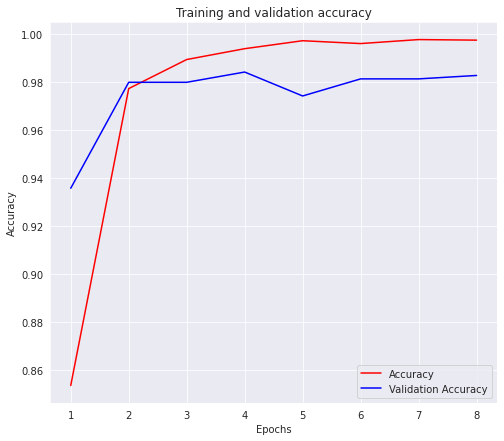

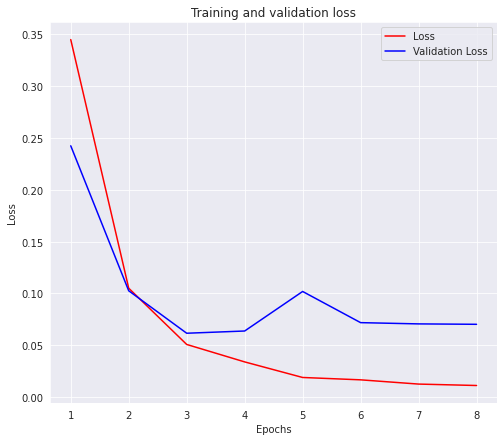

In [75]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(acc)+1) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(8,7))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(8,7))
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])



plt.show()

The best epoch seems to be at 10

In [99]:
np.random.seed(1)
tf.random.set_seed(1) # for reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(305)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               min_delta=1e-4)

lrp = tf.keraslrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1,
                                   patience=2,
                                   cooldown=2,
                                   verbose=1)

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    class_weight=class_weights, 
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stopping, lrp],
                    verbose=2)

print("Training Complete")

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 150, 100)          756400    
_________________________________________________________________
dropout_22 (Dropout)         (None, 150, 100)          0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 610)               990640    
_________________________________________________________________
dropout_23 (Dropout)         (None, 610)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 611       
Total params: 1,747,651
Trainable params: 1,747,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
132/132 - 7s - loss: 0.3568 - accuracy: 0.8486 - val_loss: 0.1668 - val_accuracy: 0.9672
Epoch 2/1

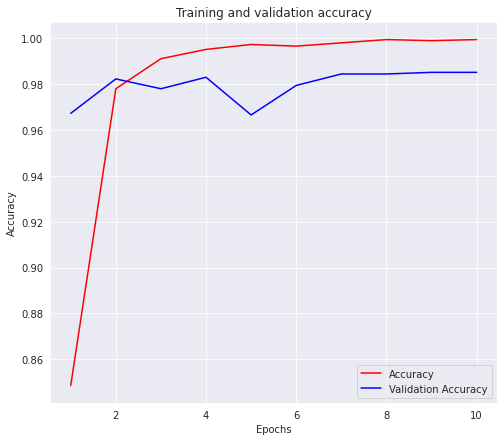

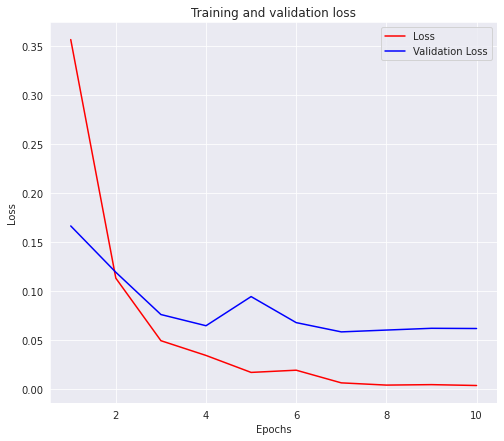

In [100]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(acc)+1) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(8,7))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(8,7))
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()


# Prediction and Evaluation

In [101]:
score = model.evaluate(test_sequences, test_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

44/44 [==============================] - 1s 15ms/step - loss: 0.0622 - accuracy: 0.9850
Test loss: 0.062150973826646805
Test accuracy: 0.9850106835365295


In [102]:
y_pred_train = model.predict(training_sequences)
y_pred_test = model.predict(test_sequences)

In [103]:
y_pred_test[4]

array([7.971373e-06], dtype=float32)

In [104]:
y_pred_train = [int(np.round(i)) for i in y_pred_train]
y_pred_test = [int(np.round(i)) for i in y_pred_test]

In [105]:
y_pred_test[4]

0

In [106]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, roc_auc_score, confusion_matrix, classification_report

In [107]:
print(classification_report(test_labels, y_pred_test, digits=2))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1134
           1       0.98      0.94      0.96       267

    accuracy                           0.99      1401
   macro avg       0.98      0.97      0.98      1401
weighted avg       0.98      0.99      0.98      1401



In [108]:
print('Training F1 score: {:.4f}'.format(\
    f1_score(training_labels, y_pred_train)))
      
print('Testing F1 score: {:.4f}'.format(\
    f1_score(test_labels, y_pred_test)))

print('\n')

print('Training precision_score: {:.4f}'.format(\
    precision_score(training_labels, y_pred_train)))
      
print('Testing precision_score: {:.4f}'.format(\
    precision_score(test_labels, y_pred_test)))

Training F1 score: 0.9982
Testing F1 score: 0.9600


Training precision_score: 0.9988
Testing precision_score: 0.9767


Note: the f1 score is taking spam as it's positive class

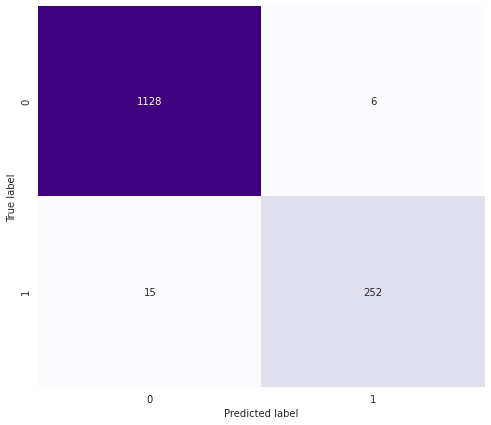

In [109]:
plt.figure(figsize=(8,7))
conf_mat = confusion_matrix(test_labels, y_pred_test)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Purples", cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()